# Calculations VGG

To do
- Check whether after blinding, the same image missdetected -> mostly yes
- Check where the new errors lie in the t-SNE

In [1]:
# imports
%load_ext autoreload
%autoreload 2

# import
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import helpers as hlp
from scipy.linalg import orth
from sklearn.linear_model import LogisticRegression

mystore = r'C:\Daten\_tmp\FRdata.h5'
rd = hlp.H5Reader2()

In [2]:
with pd.HDFStore(mystore) as store:
    print(store.keys())

['/accuracies', '/accuracies_gblinded', '/accuracies_logit_only_128', '/accuracies_rblinded', '/accuracies_rgblinded', '/awareness_predictions', '/clf_predict_indices', '/clf_predict_indices_facenet', '/clf_predict_indices_openface', '/cluster_eucl_distances', '/cluster_eucl_distances_3d', '/ethnicity_fr_rates', '/logit_race_f1', '/nn_eucl_distances', '/nn_indices', '/pair_predictions', '/pair_predictions_facenet', '/pair_predictions_openface', '/t_SNE_FaceNet', '/t_SNE_aware', '/t_SNE_blinded', '/t_SNE_openface', '/t_SNE_openface2', '/t_SNE_vgg128']


In [3]:
with pd.HDFStore(mystore) as store:
    #store.remove(nnkey)
    pass

In [4]:
# function to add columns
def hdf_add_col(path, key, col, data):
    with pd.HDFStore(mystore) as store:
        keys = store.keys()
    if key in [key.strip('/') for key in keys]:
        df = pd.read_hdf(path, key)
        df[col] = data
    else:
        df = pd.DataFrame(data,columns=[col])
    df.to_hdf(path, key)

In [5]:
# loading the data
X128, yr = hlp.H5Reader.df2data(hlp.H5Reader('senet50_128').read_all()) 
X256, _ = hlp.H5Reader.df2data(hlp.H5Reader('senet50_256').read_all())  
Xft, _ = hlp.H5Reader.df2data(hlp.H5Reader('senet50_ft').read_all())  
race_labels = pd.Series(yr).apply(hlp.H5Reader.race).values
yg = hlp.H5Reader('senet50_128').read_age_gender().gender.values
age_fun = lambda x: 1 - (x<30) + (x>45)
ya = hlp.H5Reader('senet50_128').read_age_gender().age.apply(age_fun).values

id_labels = hlp.H5Reader('senet50_128').read_pair_labels()
id_labels = np.array([label[:-5] for label in id_labels])
ids = pd.CategoricalIndex(id_labels).codes

In [5]:
race_labels

array(['Caucasian', 'Caucasian', 'Caucasian', ..., 'African', 'African',
       'African'], dtype=object)

In [6]:
# generator function to loop over all embeddings
def X_generator(X_dict, y_args_dict,verbose=False,cosine=True):
    for model, X in X_dict.items():
        for blinding, y_args in y_args_dict.items():
            if len(y_args) == 0:
                yield model+'-'+blinding+'-e',X
            else:
                Xb = blind(X,*y_args,verbose=verbose)[0]
                yield model+'-'+blinding+'-e',Xb
                if cosine:
                    yield model+'-'+blinding+'-c',Xb/np.linalg.norm(Xb,axis=1,keepdims=True)

In [7]:
# statistics of nbr of images for a given person id
(pd.DataFrame(ids,columns=['id'])
 .assign(img_nbr=1,race=yr)
 .groupby(['id','race']).count()
 .reset_index()
 .groupby(['race','img_nbr']).count()
 .reset_index()
 .pivot(index='img_nbr',columns='race',values='id'))

race,0,1,2,3
img_nbr,,,,
1,9.0,14.0,7.0,2.0
2,362.0,339.0,206.0,284.0
3,1377.0,1416.0,902.0,1437.0
4,881.0,881.0,722.0,904.0
5,270.0,259.0,413.0,315.0
6,52.0,63.0,176.0,46.0
7,7.0,12.0,60.0,7.0
8,NaN,NaN,6.0,NaN


In [8]:
# function for blinding
def blind(Xin, *args, verbose = True):
    X = Xin.astype(np.float64)
    Ne = X.shape[1]  # size of the empedding space
    V = np.zeros([0,Ne])
    
    V = []
    for y in args:
        y_unique = np.unique(y[np.isfinite(y)]).astype(int)
        centers = np.array([np.mean(X[y==k,:],0) for k in y_unique])  # centers of the clusters
        V.append(np.array([centers[k] - np.mean(centers[y_unique!=k,:],0) for k in y_unique])) 
        
    V = np.concatenate(V,0)
    U = V / np.linalg.norm(V,axis=1,keepdims=True) # normalizing
    B = orth(U.T).T  # orthogal basis spanned by the vectors
    P = np.eye(Ne) - np.matmul(B.T,B)  # construct projection matrix
    Xb = np.matmul(X,P) # projection
    
    if verbose:
        print('eigenvalues of B =',np.linalg.svd(B)[1]) # as a check

    return Xb.astype(np.float32), U.astype(np.float32)

Xb, U = blind(X128,yr,yg)

eigenvalues of B = [1. 1. 1. 1.]


## Awareness with different classifiers

In [9]:
from sklearn.model_selection import GroupKFold
class ModelBenchmarker:
    def __init__(self, imglabel, n_splits=2):
        group_kfold = GroupKFold(n_splits=n_splits)
        self.indices = [res for res in group_kfold.split(imglabel, groups=imglabel)]
                  
    def predict(self, clf, X, y):
        y_pred = np.zeros(y.shape)
        for itrain,itest in self.indices:            
            X_train = X[itrain,:] 
            y_train = y[itrain] 
            good = np.isfinite(y_train)
            X_train = X_train[good,:]
            y_train = y_train[good]
   
            clf.fit(X_train, y_train)
            y_pred[itest] = clf.predict(X[itest,:])
        return y_pred.astype(np.uint8)
        
mb = ModelBenchmarker(ids,n_splits=2)
#clf = LogisticRegression(random_state=0,max_iter=200,solver='sag')
#y_pred = mb.predict(clf, X128, ya)

In [ ]:
# this will take ages
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import NearestCentroid
clf_dict = {'Logit':LogisticRegression(random_state=0,max_iter=200,solver='sag'),
            'KNN5':KNeighborsClassifier(5),
            'NN1':MLPClassifier(alpha=1, max_iter=1000,hidden_layer_sizes=[100]) ,
            'NN2':MLPClassifier(alpha=1, max_iter=1000,hidden_layer_sizes=[100,20])}
clf_dict = {'Centroid':NearestCentroid()}
y_dict = {'r':yr, 'g':yg, 'a':ya}
X_dict = {'128':X128, '256':X256, 'ft':Xft}
y_args_dict = {'n':[],'r':[yr],'g':[yg],'rg':[yr, yg]}
for X_name,X in X_generator(X_dict,y_args_dict):
    for clf_name, clf in clf_dict.items():
        for y_name, y in y_dict.items():
            col_name = clf_name + '-' + X_name + '-' + y_name
            y_pred = mb.predict(clf, X, y)
            hdf_add_col(mystore,'clf_predict_indices',col_name,y_pred)
            print(col_name,'done ...')

In [30]:
from sklearn.neighbors import NearestCentroid
clf = NearestCentroid()
clf.fit(X128,yr)

NearestCentroid()

In [31]:
np.linalg.norm(clf.centroids_,axis=1)

array([0.19290803, 0.41709877, 0.43128033, 0.45877022])

In [33]:
from collections import Counter
Xr = np.random.normal(size=[100000,128])
Xr = Xr/np.linalg.norm(Xr, axis=1,keepdims=True)
yp = clf.predict(Xr)
Counter(yp)

Counter({0: 88888, 1: 4722, 2: 3878, 3: 2512})

In [39]:
from sklearn.neighbors import NearestCentroid
X, df = hlp.H5Reader2().read('VGG128')
yg = df.gender.cat.codes.values
clf = NearestCentroid()
clf.fit(X,yg)

NearestCentroid()

In [40]:
np.linalg.norm(clf.centroids_,axis=1)

array([0.23333204, 0.23562627])

In [41]:
hlp.H5Reader2.gender_list

['Female', 'Male']

In [46]:
from collections import Counter
Xr = np.random.normal(size=[100000,X.shape[1]])
Xr = Xr/np.linalg.norm(Xr, axis=1,keepdims=True)
yp = clf.predict(Xr)
Counter(yp)

Counter({0: 50590, 1: 49410})

In [49]:
from sklearn.neighbors import NearestCentroid
X, df = hlp.H5Reader2().read('VGG128')
ya = df.age.cat.codes.values
clf = NearestCentroid()
clf.fit(X,ya)

NearestCentroid()

In [50]:
np.linalg.norm(clf.centroids_,axis=1)

array([0.20242881, 0.20277571, 0.41579861])

In [52]:
Counter(ya)

Counter({1: 35085, 2: 2268, 0: 2966})

In [53]:
clf.classes_

array([0, 1, 2], dtype=int8)

In [51]:
hlp.H5Reader2.age_list

['<30', '30-45', '45+']

In [54]:
from collections import Counter
Xr = np.random.normal(size=[100000,X.shape[1]])
Xr = Xr/np.linalg.norm(Xr, axis=1,keepdims=True)
yp = clf.predict(Xr)
Counter(yp)

Counter({0: 49846, 1: 48668, 2: 1486})

In [59]:
from sklearn.linear_model import LogisticRegression
clf2 = LogisticRegression(max_iter=200)
clf2.fit(X,yg)
yp = clf2.predict(Xr)
Counter(yp)

Counter({1: 65284, 0: 34716})

## Face Recognition Rate (with pair metric)

In [6]:
# prepare distance class
frm = hlp.RFWDistances()
frm._df.insert(3,'subject2', frm._df['label2'].apply(lambda s: s[:-5]))
frm._df.insert(3,'subject1', frm._df['label1'].apply(lambda s: s[:-5]))
frm._df.insert(1,'age', rd.agegen_df.reindex(frm._df.subject1)['age'].astype(str).values)
frm._df.insert(1,'gender', rd.agegen_df.reindex(frm._df.subject1)['gender'].astype(str).values)
frm._df.head()

,race,gender,age,label1,label2,subject1,subject2,issame
0,Caucasian,Female,30-45,Caucasian_027n6t8_0003,Caucasian_027n6t8_0002,Caucasian_027n6t8,Caucasian_027n6t8,1
1,Caucasian,Male,30-45,Caucasian_016lb3_0004,Caucasian_016lb3_0002,Caucasian_016lb3,Caucasian_016lb3,1
2,Caucasian,Male,30-45,Caucasian_02_4qt_0003,Caucasian_02_4qt_0002,Caucasian_02_4qt,Caucasian_02_4qt,1
3,Caucasian,Male,30-45,Caucasian_09g8fj_0003,Caucasian_09g8fj_0001,Caucasian_09g8fj,Caucasian_09g8fj,1
4,Caucasian,Female,30-45,Caucasian_01q3xr_0001,Caucasian_01q3xr_0003,Caucasian_01q3xr,Caucasian_01q3xr,1


In [30]:
# prepare distance class for 
_, df = rd.read('VGG128')
X_dict = {mod:rd.read('VGG'+mod)[0] for mod in ['128','256','ft']}
y_args_dict = {'n':[],'r':[df.race.cat.codes.values],'g':[df.gender.cat.codes.values]}
dist_df = pd.DataFrame()
for name,X in X_generator(X_dict,y_args_dict,verbose=True):
    dist_df[name] = frm.get_distance_df(X,df['img'])['eucl']

eigenvalues of B = [1. 1. 1.]
eigenvalues of B = [1.]
eigenvalues of B = [1. 1. 1.]
eigenvalues of B = [1.]
eigenvalues of B = [1. 1. 1.]
eigenvalues of B = [1.]


In [46]:
#from sklearn.neighbors import NearestCentroid
#clf = NearestCentroid()
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression()
pred_df = dist_df.copy() * np.nan
for col in dist_df.columns:
    sel = np.isfinite(dist_df[col])
    X = dist_df[[col]].values
    y = frm._df.issame
    clf.fit(X[sel,:],y[sel])
    pred_df.loc[sel,col] = np.float16(clf.predict(X[sel]) == y[sel])

pred_df = pd.concat([frm._df,pred_df],1)
pred_df.to_hdf(mystore,'pair_predictions')

### include distances to centroids

In [12]:
from sklearn.neighbors import NearestCentroid

X, tmp = rd.read('VGG128')

df = frm.get_distance_df(X128,tmp['img'])
X1, X2 = frm._get_metric_empeddings(X128, tmp['img'])
Xm = (X1 + X2)/2

clf = NearestCentroid()
clf.fit(X,yr)
for ii,centroid in enumerate(clf.centroids_):
    df['centroid'+str(ii)] = np.linalg.norm(Xm - centroid,axis=1)
     
df.head()

,race,gender,age,label1,label2,subject1,subject2,issame,cos,eucl,centroid0,centroid1,centroid2,centroid3
0,Caucasian,Female,30-45,Caucasian_027n6t8_0003,Caucasian_027n6t8_0002,Caucasian_027n6t8,Caucasian_027n6t8,1,0.397336,0.891444,0.886222,0.971236,0.995558,1.078156
1,Caucasian,Male,30-45,Caucasian_016lb3_0004,Caucasian_016lb3_0002,Caucasian_016lb3,Caucasian_016lb3,1,0.355929,0.843717,0.814462,0.970098,1.025648,0.995125
2,Caucasian,Male,30-45,Caucasian_02_4qt_0003,Caucasian_02_4qt_0002,Caucasian_02_4qt,Caucasian_02_4qt,1,0.330190,0.812638,0.868932,0.950798,1.016252,1.009883
3,Caucasian,Male,30-45,Caucasian_09g8fj_0003,Caucasian_09g8fj_0001,Caucasian_09g8fj,Caucasian_09g8fj,1,0.294455,0.767405,0.888712,1.067939,1.033508,0.993351
4,Caucasian,Female,30-45,Caucasian_01q3xr_0001,Caucasian_01q3xr_0003,Caucasian_01q3xr,Caucasian_01q3xr,1,0.280291,0.748720,0.908872,0.991889,0.971504,1.128042


In [13]:
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression()
sel = np.isfinite(df.eucl.values)

cols = ['eucl']
clf.fit(df[sel][cols].values,df[sel].issame.values)
print('without centroids',clf.score(df[sel][cols].values,df[sel].issame.values))

cols = ['eucl','centroid0','centroid1','centroid2','centroid3']
clf.fit(df[sel][cols].values,df[sel].issame.values)
print('with centroids',clf.score(df[sel][cols].values,df[sel].issame.values))

without centroids 0.8654659225435481
with centroids 0.8852528327414172


In [17]:
cols = ['eucl','centroid0','centroid1','centroid2','centroid3']
clf.fit(df[sel][cols].values,df[sel].issame.values)
df.loc[sel,'pred'] = clf.predict(df[sel][cols].values) == df[sel].issame.values 
hdf_add_col(mystore, 'pair_predictions', '128-n-e-c', df['pred'].values)

C:\Users\wehs\.conda\envs\ds\lib\site-packages\pandas\core\generic.py:2505: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block2_values] [items->Index(['race', 'gender', 'age', 'label1', 'label2', 'subject1', 'subject2',
       '128-n-e-c'],
      dtype='object')]

  encoding=encoding,


In [16]:
df

,race,gender,age,label1,label2,subject1,subject2,issame,cos,eucl,centroid0,centroid1,centroid2,centroid3,pred
0,Caucasian,Female,30-45,Caucasian_027n6t8_0003,Caucasian_027n6t8_0002,Caucasian_027n6t8,Caucasian_027n6t8,1,0.397336,0.891444,0.886222,0.971236,0.995558,1.078156,True
1,Caucasian,Male,30-45,Caucasian_016lb3_0004,Caucasian_016lb3_0002,Caucasian_016lb3,Caucasian_016lb3,1,0.355929,0.843717,0.814462,0.970098,1.025648,0.995125,True
2,Caucasian,Male,30-45,Caucasian_02_4qt_0003,Caucasian_02_4qt_0002,Caucasian_02_4qt,Caucasian_02_4qt,1,0.330190,0.812638,0.868932,0.950798,1.016252,1.009883,True
3,Caucasian,Male,30-45,Caucasian_09g8fj_0003,Caucasian_09g8fj_0001,Caucasian_09g8fj,Caucasian_09g8fj,1,0.294455,0.767405,0.888712,1.067939,1.033508,0.993351,True
4,Caucasian,Female,30-45,Caucasian_01q3xr_0001,Caucasian_01q3xr_0003,Caucasian_01q3xr,Caucasian_01q3xr,1,0.280291,0.748720,0.908872,0.991889,0.971504,1.128042,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23995,African,Male,30-45,African_04zxpvp_0003,African_02r1g27_0003,African_04zxpvp,African_02r1g27,0,0.457321,0.956369,0.910952,0.998526,0.965703,0.740548,True
23996,African,Male,30-45,African_03gymy_0005,African_02x35pc_0002,African_03gymy,African_02x35pc,0,0.830698,1.288951,0.783168,0.929530,0.837384,0.576157,True
23997,African,Male,30-45,African_05p823_0004,African_0ndhf39_0002,African_05p823,African_0ndhf39,0,0.719780,1.199817,0.841002,0.911264,0.889178,0.671157,True
23998,African,Male,30-45,African_02rmtpx_0002,African_08fz0m_0003,African_02rmtpx,African_08fz0m,0,0.563480,1.061584,0.869480,0.986410,0.893682,0.720400,True


## Face Recognition Rate (with nearest neighbor)

In [51]:
# this takes ages to run ...
from sklearn.neighbors import NearestNeighbors
nnkey = 'nn_indices'
X_dict = {'128':X128, '256':X256, 'ft':Xft}
y_args_dict = {'n':[],'r':[yr],'g':[yg],'rg':[yr, yg]}
for name,X in X_generator(X_dict,y_args_dict):
    nbrs = NearestNeighbors(n_neighbors=2, algorithm='ball_tree').fit(X)
    res = nbrs.kneighbors(x,return_distance=False)[:,1].astype(np.uint16)
    hdf_add_col(mystore,nnkey,name,res)
    print(name,'done ...')

In [ ]:
# blinding with respect to only one race
from sklearn.neighbors import NearestNeighbors
nnkey = 'nn_indices'
X_dict = {'128':X128, '256':X256, 'ft':Xft}
y_args_dict = {'rca':[np.int8(yr==0)],'rin':[np.int8(yr==1)],'ras':[np.int8(yr==2)],'raf':[np.int8(yr==3)]}
for name,X in X_generator(X_dict,y_args_dict):
    nbrs = NearestNeighbors(n_neighbors=2, algorithm='ball_tree').fit(X)
    res = nbrs.kneighbors(X,return_distance=False)[:,1].astype(np.uint16)
    hdf_add_col(mystore,nnkey,name,res)
    print(name,'done ...')

### Analyse

In [37]:
df = pd.read_hdf(mystore,'nn_indices')[['128-n-e','256-n-e','ft-n-e']]
for col in df.columns:  # bool for equal identity
    df[col] = ids == ids[df[col]]
    
vals = df.values    
df['all'] = np.all(vals,1)
df['any'] = np.any(vals,1)
df['maj'] = np.sum(vals,1) >= 2
df['label'] = yr
df.groupby('label').mean()

,128-n-e,256-n-e,ft-n-e,all,any,maj
label,,,,,,
0,0.890583,0.878701,0.879889,0.828003,0.930290,0.890880
1,0.851874,0.825262,0.845514,0.774680,0.898053,0.849917
2,0.830452,0.797542,0.829827,0.736617,0.890335,0.830869
3,0.797634,0.757526,0.794075,0.691353,0.862172,0.795710


In [10]:
df = pd.read_hdf(mystore,'nn_indices')  # load
for col in df.columns:  # bool for equal identity
    df[col] = ids == ids[df[col]]

rrdf = []
rrdf.append(df.assign(Label=race_labels).groupby('Label').mean()
            .stack().reset_index().rename(columns={'level_1':'Key',0:'RecRate'}).assign(Group='Ethnicity') )

# gender
good = np.isfinite(yg)
labels = list(map(lambda g: {0.0:'Male', 1.0:'Female'}[g],yg[good]))
rrdf.append(df[good].assign(Label=labels).groupby('Label').mean()
            .stack().reset_index().rename(columns={'level_1':'Key',0:'RecRate'}).assign(Group='Gender') )

# age
good = np.isfinite(ya)
labels = list(map(lambda g: {0:'< 30', 1:'30-45', 2:'>45'}[g],ya[good]))
rrdf.append(df[good].assign(Label=labels).groupby('Label').mean()
            .stack().reset_index().rename(columns={'level_1':'Key',0:'RecRate'}).assign(Group='Age') )

rrdf = pd.concat(rrdf,0).reset_index(drop=True)

model_label = lambda s, ind:{'128':'128','256':'256','ft':'2048'}[s.split('-')[ind]]
blinding_label = lambda s, ind:{'n':'None','r':'Ethnicity','g':'Gender','rg':'Ethn.+Gend.',
                               'rca':'Caucasian','rin':'Indian','ras':'Asian','raf':'African',}[s.split('-')[ind]]
dist_label = lambda s, ind:{'e':'Eucl.','c':'Cosine'}[s.split('-')[ind]]

rrdf['Model'] = rrdf['Key'].apply(model_label,args=[0])
rrdf['Blinding'] = rrdf['Key'].apply(blinding_label,args=[1])
rrdf['Dist. Measure'] = rrdf['Key'].apply(dist_label,args=[2])

labels = [ 'Caucasian', 'Indian', 'Asian','African', 'Male', 'Female', '< 30','30-45', '>45']
rrdf['sort1'] = rrdf.Label.apply(lambda l: labels.index(l))  
models = [ '128', '256', '2048']
rrdf['sort2'] = rrdf.Model.apply(lambda m: models.index(m))  

rrdf = rrdf.sort_values(by=['sort1','sort2']).reset_index(drop=True)
    
rrdf.head()

,Label,Key,RecRate,Group,Model,Blinding,Dist. Measure,sort1,sort2
0,Caucasian,128-n-e,0.890583,Ethnicity,128,None,Eucl.,0,0
1,Caucasian,128-r-e,0.833350,Ethnicity,128,Ethnicity,Eucl.,0,0
2,Caucasian,128-r-c,0.864739,Ethnicity,128,Ethnicity,Cosine,0,0
3,Caucasian,128-g-e,0.885236,Ethnicity,128,Gender,Eucl.,0,0
4,Caucasian,128-g-c,0.885533,Ethnicity,128,Gender,Cosine,0,0


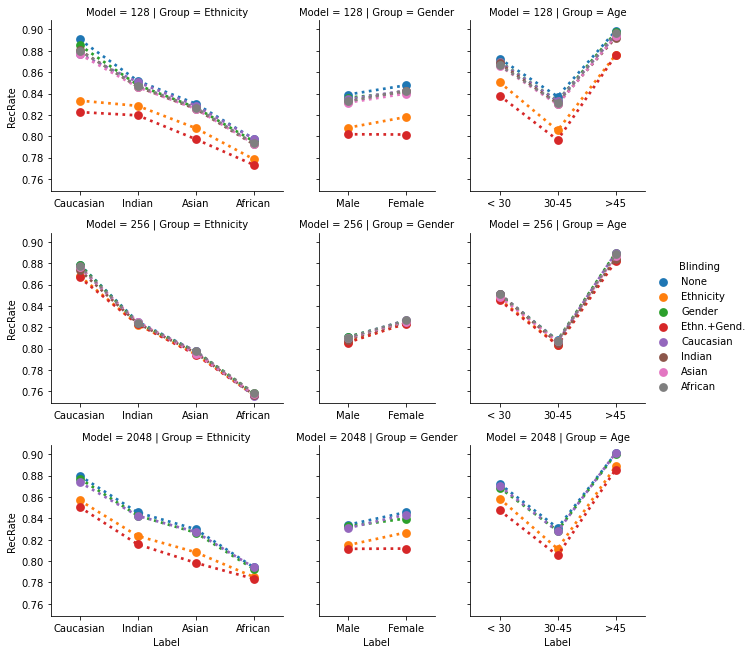

In [11]:
# plot all data
sel = rrdf['Dist. Measure'] == 'Eucl.'
p = sns.catplot(data=rrdf[sel],x='Label', y='RecRate',hue='Blinding',row='Model',col='Group', kind="point",
            sharex=False,height=3, dashes=([2,2]),facet_kws={'gridspec_kws':{'width_ratios':[4,2,3]}})
for g in p.axes.flatten():
    for l in g.lines:
        l.set_linestyle(":")
        
plt.savefig('latex/recognition_rates_with_blinding.png')

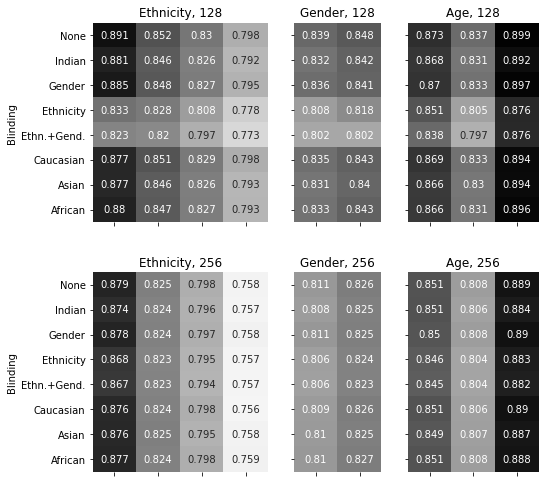

In [17]:
group_list = ['Ethnicity','Gender','Age']
model_list = ['128','256']
Ngroup, Nmod = len(group_list), len(model_list)
fig, axes = plt.subplots(Nmod,Ngroup,figsize=(8,8),sharey=True, sharex=False,gridspec_kw={'width_ratios':[4,2,3]})
plt.subplots_adjust(hspace=0.25,bottom=0.1)
for igroup, group in enumerate(group_list):
    for imodel, model in enumerate(model_list):
        sel = (rrdf.Group == group) & (rrdf.Model == model) & (rrdf['Dist. Measure']=='Eucl.')
        df = (rrdf[sel].pivot(index='Blinding',columns='Label',values='RecRate')
              .sort_index(ascending=False))
        df = df[[label for label in labels if label in df.columns]]
        g = sns.heatmap(df,cmap='binary',annot=True,cbar=False,vmin=0.75,vmax=0.90,ax=axes[imodel,igroup],fmt='.3g')
        g.set_title(group + ', '+model)
        if imodel < Nmod:
            g.set(xlabel=None)
            g.set(xticklabels=[])
        else:
            g.set(xlabel=None)

        if igroup == 0:
            g.set(ylabel='Blinding')
        else:
            g.set(ylabel=None)
        
fig.savefig('latex/recognition_rates_with_blinding2.png')

### Check wrong image classification before and after blinding

In [ ]:
badr = ids != ids[pd.read_hdf(mystore,'nn_indices')['128-n-e']]

In [38]:
cols = pd.read_hdf(mystore,'nn_indices').columns
df = pd.DataFrame(ids[pd.read_hdf(mystore,'nn_indices')] != ids.reshape([-1,1]),columns=cols)
stat_df = pd.DataFrame(df.mean().round(3).rename('error rate'))
stat_df['same error'] = np.round(np.mean(df.values & df[['128-n-e']].values,0),3)
stat_df['turned into good'] = stat_df['error rate'][0] - stat_df['same error']
stat_df

,error rate,same error,turned into good
128-n-e,0.158,0.158,0.000
128-r-e,0.188,0.152,0.006
128-r-c,0.182,0.148,0.010
128-g-e,0.161,0.155,0.003
128-g-c,0.162,0.154,0.004
256-n-e,0.185,0.120,0.038
256-r-e,0.190,0.121,0.037
256-r-c,0.186,0.120,0.038
256-g-e,0.186,0.120,0.038
256-g-c,0.185,0.120,0.038


In [35]:
stat_df.mean()

error rate     0.175689
same errors    0.134311
dtype: float64

In [26]:
df == df['128-n-e']

KeyboardInterrupt: 

## Comparing classification and face recognition errors

### Unblinded data

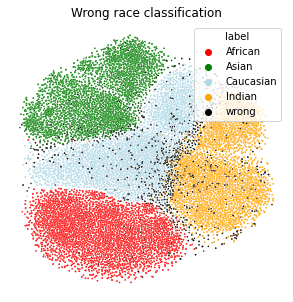

In [84]:
df = pd.read_hdf(mystore,'t_SNE_aware')
bada = pd.read_hdf(mystore,'clf_predict_indices')['NN2-128-n-e-r'] != yr
df.loc[bada,'label'] = 'wrong'
df = df.sort_values(by='label')

palette = {'Caucasian':'lightblue', 'Indian':'orange', 'Asian':'green', 'African':'red','wrong':'black'}

plt.figure(figsize=[5,5])
g = sns.scatterplot(data=df,x='x',y='y',hue='label',legend=True,s=2,palette=palette)
plt.title('Wrong race classification')
plt.axis('off')
plt.show()

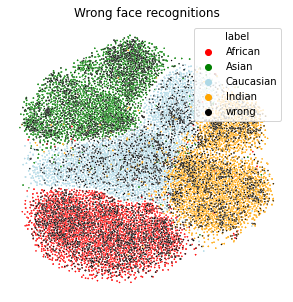

In [85]:
df = pd.read_hdf(mystore,'t_SNE_aware')
badr = ids != ids[pd.read_hdf(mystore,'nn_indices')['128-n-e']]
df.loc[badr,'label'] = 'wrong'
df = df.sort_values(by='label')

palette = {'Caucasian':'lightblue', 'Indian':'orange', 'Asian':'green', 'African':'red','wrong':'black'}

plt.figure(figsize=[5,5])
g = sns.scatterplot(data=df,x='x',y='y',hue='label',legend=True,s=2,palette=palette)
plt.title('Wrong face recognitions')
plt.axis('off')
plt.show()

In [86]:
Nids = len(ids)
print('fraction of images with wrong face recognition',np.sum(badr)/Nids)
print('fraction of images with wrong race classification',np.sum(bada)/Nids)
print('fraction of images with both',np.sum(badr&bada)/Nids)
print('lift', np.sum(badr&bada)/np.sum(bada)/np.sum(badr)*Nids )

fraction of images with wrong face recognition 0.15751878766834496
fraction of images with wrong race classification 0.037872963119124976
fraction of images with both 0.00786229817207768
lift 1.3179164066897662


### Same with blinded data

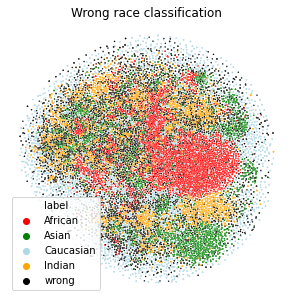

In [96]:
df = pd.read_hdf(mystore,'t_SNE_blinded')
bada = pd.read_hdf(mystore,'clf_predict_indices')['NN2-128-r-e-r'] != yr
df.loc[bada,'label'] = 'wrong'
df = df.sort_values(by='label')

palette = {'Caucasian':'lightblue', 'Indian':'orange', 'Asian':'green', 'African':'red','wrong':'black'}

plt.figure(figsize=[5,5])
g = sns.scatterplot(data=df,x='x',y='y',hue='label',legend=True,s=2,palette=palette)
plt.title('Wrong race classification')
plt.axis('off')
plt.show()

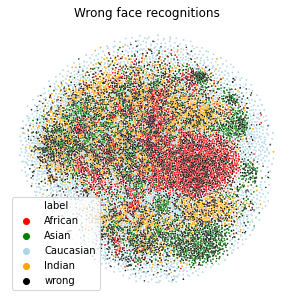

In [97]:
df = pd.read_hdf(mystore,'t_SNE_blinded')
badr = ids != ids[pd.read_hdf(mystore,'nn_indices')['128-r-e']]
df.loc[badr,'label'] = 'wrong'
df = df.sort_values(by='label')

palette = {'Caucasian':'lightblue', 'Indian':'orange', 'Asian':'green', 'African':'red','wrong':'black'}

plt.figure(figsize=[5,5])
g = sns.scatterplot(data=df,x='x',y='y',hue='label',legend=True,s=2,palette=palette)
plt.title('Wrong face recognitions')
plt.axis('off')
plt.show()

In [98]:
Nids = len(ids)
print('fraction of images with wrong face recognition',np.sum(badr)/Nids)
print('fraction of images with wrong race classification',np.sum(bada)/Nids)
print('fraction of images with both',np.sum(badr&bada)/Nids)
print('lift', np.sum(badr&bada)/np.sum(bada)/np.sum(badr)*Nids )

fraction of images with wrong face recognition 0.18814950767628166
fraction of images with wrong race classification 0.14385277412634243
fraction of images with both 0.029564225303206924
lift 1.0923081538587416


# Accuracies

of original embeddings

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, accuracy_score
img_labels = hlp.H5Reader('senet50_128').read_img_labels()
img_labels = [il[:-5] for il in img_labels]

class ModelBenchmarker:
    def __init__(self, yimg, test_size=0.33, random_state=42):
        yimg_train, yimg_test =  train_test_split(np.unique(yimg), test_size=test_size, random_state=random_state)
        self.sel_train = pd.Series(yimg).isin(yimg_train) 
        self.sel_test = pd.Series(yimg).isin(yimg_test) 
          
    def benchmark(self, clf, X, y):
        X_train = X[self.sel_train,:] 
        y_train = y[self.sel_train] 
        good = np.isfinite(y_train)
        X_train = X_train[good,:]
        y_train = y_train[good]
        
        X_test = X[self.sel_test,:] 
        y_test = y[self.sel_test] 
        good = np.isfinite(y_test)
        X_test = X_test[good,:]
        y_test = y_test[good]
       
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)
        out = [accuracy_score(y_test,y_pred),
               f1_score(y_test,y_pred,average='micro'),
               f1_score(y_test,y_pred,average='macro'),
               f1_score(y_test,y_pred,average='weighted')]
        return out
        
mb = ModelBenchmarker(img_labels)

In [5]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier

clf_dict = {'a_Logit':LogisticRegression(random_state=0,max_iter=200,solver='sag'),
            'b_LinSVM':SVC(kernel="linear", C=0.025),
            'c_KNN1':KNeighborsClassifier(1),
            'd_KNN10':KNeighborsClassifier(10),
            'e_NN1':MLPClassifier(alpha=1, max_iter=1000,hidden_layer_sizes=[100]) ,
            'f_NN2':MLPClassifier(alpha=1, max_iter=1000,hidden_layer_sizes=[100,100])}

In [6]:
X_dict = {'0128':X128, '0256':X256, '2048':Xft}
y_dict = {'race':yr, 'gender':yg, 'age':ya}

df = []
col_dict = {'clf':str,'X':str,'y':str,'acc':float,'f1i':float,'f1a':float,'f1w':float}
for clf_name, clf in clf_dict.items():
    for X_name, X in X_dict.items():
        for y_name, y in y_dict.items():
            res = mb.benchmark(clf,X,y)
            # acc,f1 = 3.5,7
            df.append(pd.DataFrame([clf_name,X_name,y_name]+res,col_dict.keys()).T)
    pd.concat(df,0).astype(col_dict).reset_index().to_hdf(mystore, 'accuracies')
    print(clf_name,'done ...')

a_Logit done ...
b_LinSVM done ...
c_KNN1 done ...
d_KNN10 done ...
e_NN1 done ...
f_NN2 done ...


In [ ]:
X_dict = {'0128':blind(X128,yr)[0], '0256':blind(X256,yr)[0], '2048':blind(Xft,yr)[0]}
y_dict = {'race':yr, 'gender':yg, 'age':ya}

df = []
col_dict = {'clf':str,'X':str,'y':str,'acc':float,'f1i':float,'f1a':float,'f1w':float}
for clf_name, clf in clf_dict.items():
    for X_name, X in X_dict.items():
        for y_name, y in y_dict.items():
            res = mb.benchmark(clf,X,y)
            # acc,f1 = 3.5,7
            df.append(pd.DataFrame([clf_name,X_name,y_name]+res,col_dict.keys()).T)
    pd.concat(df,0).astype(col_dict).reset_index().to_hdf(mystore, 'accuracies_rblinded')
    print(clf_name,'done ...')

eigenvalues of B = [1. 1. 1.]
eigenvalues of B = [1. 1. 1.]
eigenvalues of B = [1. 1. 1.]


In [21]:
df = (pd.read_hdf(mystore,'accuracies')
      .drop(columns='index')
      .groupby('y')
      .apply(lambda sdf: pd.pivot(sdf,index='X',columns='clf',values='f1a'))
      .round(3)) 
df

clf          a_Logit  b_LinSVM  c_KNN1  d_KNN10  e_NN1  f_NN2
y      X                                                     
age    0128    0.492     0.313   0.485    0.448  0.356  0.406
       0256    0.479     0.313   0.472    0.418  0.338  0.420
       2048    0.494     0.313   0.491    0.488  0.323  0.450
gender 0128    0.913     0.912   0.845    0.891  0.910  0.914
       0256    0.846     0.790   0.849    0.891  0.804  0.888
       2048    0.917     0.914   0.861    0.902  0.912  0.915
race   0128    0.961     0.959   0.916    0.950  0.960  0.961
       0256    0.956     0.954   0.912    0.947  0.954  0.955
       2048    0.960     0.958   0.907    0.945  0.959  0.958

In [23]:
print(df.to_latex())  

\begin{tabular}{llrrrrrr}
\toprule
     & clf &  a\_Logit &  b\_LinSVM &  c\_KNN1 &  d\_KNN10 &  e\_NN1 &  f\_NN2 \\
y & X &          &           &         &          &        &        \\
\midrule
age & 0128 &    0.492 &     0.313 &   0.485 &    0.448 &  0.356 &  0.406 \\
     & 0256 &    0.479 &     0.313 &   0.472 &    0.418 &  0.338 &  0.420 \\
     & 2048 &    0.494 &     0.313 &   0.491 &    0.488 &  0.323 &  0.450 \\
gender & 0128 &    0.913 &     0.912 &   0.845 &    0.891 &  0.910 &  0.914 \\
     & 0256 &    0.846 &     0.790 &   0.849 &    0.891 &  0.804 &  0.888 \\
     & 2048 &    0.917 &     0.914 &   0.861 &    0.902 &  0.912 &  0.915 \\
race & 0128 &    0.961 &     0.959 &   0.916 &    0.950 &  0.960 &  0.961 \\
     & 0256 &    0.956 &     0.954 &   0.912 &    0.947 &  0.954 &  0.955 \\
     & 2048 &    0.960 &     0.958 &   0.907 &    0.945 &  0.959 &  0.958 \\
\bottomrule
\end{tabular}



### blinding

In [47]:
X_dict = {'None':X128, 'race':blind(X128,yr)[0], 'gender':blind(X128,yg)[0], 'race+gender':blind(X128,yr,yg)[0]}
y_dict = {'race':yr, 'gender':yg}

df = []
col_dict = {'clf':str,'X':str,'y':str,'acc':float,'f1i':float,'f1a':float,'f1w':float}
for clf_name, clf in list(clf_dict.items())[:1]:
    for X_name, X in X_dict.items():
        for y_name, y in y_dict.items():
            res = mb.benchmark(clf,X,y)
            # acc,f1 = 3.5,7
            df.append(pd.DataFrame([clf_name,X_name,y_name]+res,col_dict.keys()).T)
    pd.concat(df,0).astype(col_dict).reset_index().to_hdf(mystore, 'accuracies_logit_only_128')
    print(clf_name,'done ...')

eigenvalues of B = [1. 1. 1.]
eigenvalues of B = [1.]
eigenvalues of B = [1. 1. 1. 1.]
a_Logit done ...


In [60]:
h5keys = {'None':'accuracies',
          'race':'accuracies_rblinded',
          'gender':'accuracies_gblinded',
          'race+gender':'accuracies_rgblinded'}
df = [pd.read_hdf(mystore,key).assign(blinding=name) for name,key in h5keys.items()]
df = (pd.concat(df,0)
      .query("X=='0128'")
      .groupby('y')
      .apply(lambda sdf: pd.pivot(sdf,index='blinding',columns='clf',values='f1a'))
      .round(3)) 
df

clf                 a_Logit  b_LinSVM  c_KNN1  d_KNN10  e_NN1  f_NN2
y      blinding                                                     
age    None           0.492     0.313   0.485    0.448  0.356  0.406
       gender         0.483     0.313   0.479    0.432  0.356  0.427
       race           0.491     0.313   0.471    0.414  0.345  0.401
       race+gender    0.479     0.313   0.456    0.390  0.337  0.383
gender None           0.913     0.912   0.845    0.891  0.910  0.914
       gender         0.427     0.427   0.778    0.801  0.773  0.897
       race           0.909     0.906   0.803    0.831  0.904  0.910
       race+gender    0.427     0.427   0.703    0.670  0.640  0.828
race   None           0.961     0.959   0.916    0.950  0.960  0.961
       gender         0.959     0.958   0.903    0.942  0.958  0.958
       race           0.196     0.123   0.544    0.586  0.707  0.857
       race+gender    0.198     0.119   0.509    0.545  0.542  0.103

In [61]:
print(df.to_latex())  

\begin{tabular}{llrrrrrr}
\toprule
     & clf &  a\_Logit &  b\_LinSVM &  c\_KNN1 &  d\_KNN10 &  e\_NN1 &  f\_NN2 \\
y & blinding &          &           &         &          &        &        \\
\midrule
age & None &    0.492 &     0.313 &   0.485 &    0.448 &  0.356 &  0.406 \\
     & gender &    0.483 &     0.313 &   0.479 &    0.432 &  0.356 &  0.427 \\
     & race &    0.491 &     0.313 &   0.471 &    0.414 &  0.345 &  0.401 \\
     & race+gender &    0.479 &     0.313 &   0.456 &    0.390 &  0.337 &  0.383 \\
gender & None &    0.913 &     0.912 &   0.845 &    0.891 &  0.910 &  0.914 \\
     & gender &    0.427 &     0.427 &   0.778 &    0.801 &  0.773 &  0.897 \\
     & race &    0.909 &     0.906 &   0.803 &    0.831 &  0.904 &  0.910 \\
     & race+gender &    0.427 &     0.427 &   0.703 &    0.670 &  0.640 &  0.828 \\
race & None &    0.961 &     0.959 &   0.916 &    0.950 &  0.960 &  0.961 \\
     & gender &    0.959 &     0.958 &   0.903 &    0.942 &  0.958 &  0.958 \\
     

### t-SNE for Senet_128

In [75]:
df = pd.read_hdf(mystore,'t_SNE_aware')
df['img_labels'] = hlp.H5Reader('senet50_128').read_pair_labels()
df.to_csv('t_SNE_coordinates.csv')

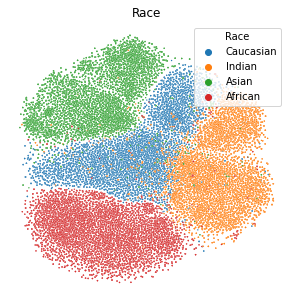

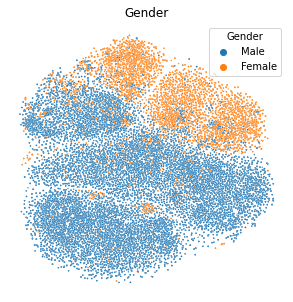

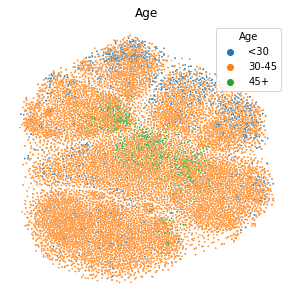

In [8]:
tmp = pd.read_hdf(mystore,'t_SNE_aware')
tmp['Gender'] = pd.Series(yg).apply(str).apply(lambda s: {'0.0':'Male', '1.0':'Female', 'nan':'nan'}[s])
age_classes = ['<30','30-45','45+']
tmp['Age'] = pd.Series(ya).apply(lambda i: age_classes[i])
tmp = tmp.rename(columns={'label':'Race'})

# aware data
plt.figure(figsize=[5,5])
g = sns.scatterplot(data=tmp,x='x',y='y',hue='Race',legend=True,s=2,)
plt.title('Race')
plt.axis('off')
plt.savefig("latex/t-SNE_aware_race.png")
plt.show()

plt.figure(figsize=[5,5])
sel = tmp.Gender.isin(['Male','Female'])
g = sns.scatterplot(data=tmp[sel],x='x',y='y',hue='Gender',legend=True,s=2)
plt.title('Gender')
plt.axis('off')
plt.savefig("latex/t-SNE_aware_gender.png")
plt.show()

plt.figure(figsize=[5,5])
g = sns.scatterplot(data=tmp,x='x',y='y',hue='Age',legend=True,s=2,hue_order=age_classes)
plt.title('Age')
plt.axis('off')
plt.savefig("latex/t-SNE_aware_age.png")
plt.show()

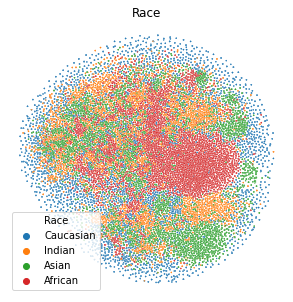

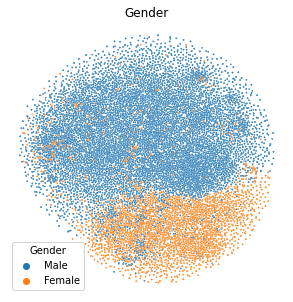

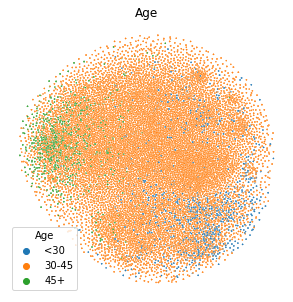

In [9]:
tmp = pd.read_hdf(mystore,'t_SNE_blinded')
tmp['Gender'] = pd.Series(yg).apply(str).apply(lambda s: {'0.0':'Male', '1.0':'Female', 'nan':'nan'}[s])
age_classes = ['<30','30-45','45+']
tmp['Age'] = pd.Series(ya).apply(lambda i: age_classes[i])
tmp = tmp.rename(columns={'label':'Race'})

# aware data
plt.figure(figsize=[5,5])
g = sns.scatterplot(data=tmp,x='x',y='y',hue='Race',legend=True,s=2,)
plt.title('Race')
plt.axis('off')
plt.savefig("latex/t-SNE_blinded_race.png")
plt.show()

plt.figure(figsize=[5,5])
sel = tmp.Gender.isin(['Male','Female'])
g = sns.scatterplot(data=tmp[sel],x='x',y='y',hue='Gender',legend=True,s=2)
plt.title('Gender')
plt.axis('off')
plt.savefig("latex/t-SNE_blinded_gender.png")
plt.show()

plt.figure(figsize=[5,5])
g = sns.scatterplot(data=tmp,x='x',y='y',hue='Age',legend=True,s=2,hue_order=age_classes)
plt.title('Age')
plt.axis('off')
plt.savefig("latex/t-SNE_blinded_age.png")
plt.show()

# Blinding

In [81]:
# step 1: remove race dimensions
def blind(Xin, yrace, ygender=None):
    X = Xin.astype(np.float64)

    yr_unique = np.unique(yrace)  
    Ne = X.shape[1]  # size of the empedding space

    centers = np.array([np.mean(X[yrace==k,:],0) for k in yr_unique])  # centers of the clusters

    # vectors from each center to averege of the other centers
    V = np.array([centers[k] - np.mean(centers[yr_unique!=k,:],0) for k in yr_unique])
    
    if ygender is not None:
        Vg = np.mean(X[(ygender==0),:],0,keepdims=True) - np.mean(X[(ygender==1),:],0,keepdims=True)
        V = np.concatenate([V,Vg],0)

    U = V / np.linalg.norm(V,axis=1,keepdims=True) # normalizing

    # orthogal basis spanned by the vectors
    B = orth(U.T).T  
    print('eigenvalues of B =',np.linalg.svd(B)[1])

    # projection matrix
    P = np.eye(Ne) - np.matmul(B.T,B)

    # projection
    Xb = np.matmul(X,P)
    
    return Xb.astype(np.float32), U.astype(np.float32)

Xb, U = blind(X128,yr)

eigenvalues of B = [1. 1. 1.]


## Visualization

The outlined procedure is based on vectors (in the embedding space) which point from one CoM to average of the remaining CoM. This is verly similar to the concept of one-vs-rest concept for linear regression. The result are four vectors for the four racial clusters. The projections onto these normalized vectors are shown in the plot. Obviously, the clusters are well separated along these direction. I.e. **the original embedding literally puts different races into different corners!**

In [41]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, accuracy_score

Xb, _ = blind(X256,yr,yg)
clf = LogisticRegression(random_state=0,max_iter=200,solver='sag')

sel = np.isfinite(yg)
clf.fit(Xb[sel,:],yg[sel])
y2 = clf.predict(Xb[sel,:])
# clf.score(Xb[sel],yg[sel])
print(f1_score(yg[sel],y2,))
print(accuracy_score(yg[sel],y2))

eigenvalues of B = [1. 1. 1. 1.]
0.0
0.7456440040997608


C:\Users\wehs\.conda\envs\ds\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


eigenvalues of B = [1. 1. 1.]


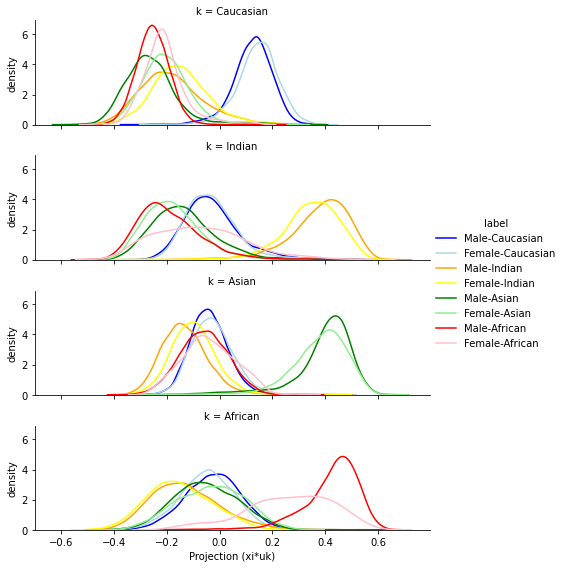

In [42]:
# normalized vectors for subsequent projections in the vis
X = X128

_, U = blind(X,yr)
columns =  np.array(hlp.H5Reader.race_list + ['gender'])[:U.shape[0]]
df = pd.DataFrame(np.matmul(X[sel,:],U.T),columns=columns)
df['race_label'] = race_labels[sel]
df['gender_label'] = pd.Series(yg[sel]).astype(int).apply(lambda i: ['Male','Female'][i])
df['label'] = df.gender_label + '-' + df.race_label
df = (df.set_index(['race_label','gender_label','label'])
      .stack().reset_index()
      .rename(columns={'level_3':'k',0:'value'}))

palette = {'Male-Caucasian':'blue', 
           'Female-Caucasian':'lightblue', 
           'Male-Indian':'orange',       
           'Female-Indian':'yellow',
           'Male-Asian':'green', 
           'Female-Asian':'lightgreen', 
           'Male-African':'red',
           'Female-African':'pink'}

g = sns.FacetGrid(df,row='k',hue='label',aspect=3,height=2, legend_out=True,
                  palette=palette)
g.map(sns.kdeplot, 'value',common_norm=True)
g.add_legend()
for ax in g.axes.flat:
    ax.set_ylabel('density')
plt.xlabel('Projection (xi*uk)')    
g.savefig("latex/projection.eps")


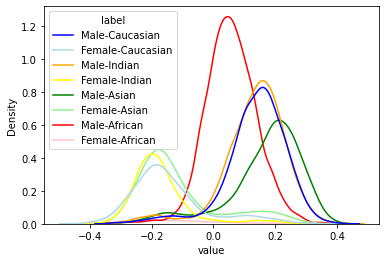

In [42]:
sns.kdeplot(data = df.query("k=='gender'"),x='value',hue='label',palette=palette)

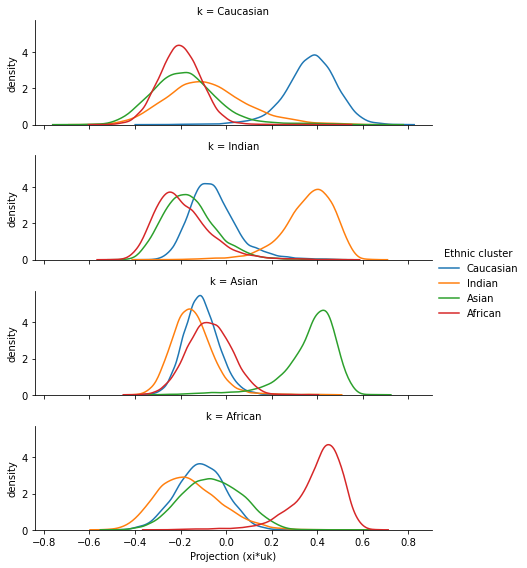

In [68]:
# normalized vectors for subsequent projections in the vis
U = V / np.linalg.norm(V,axis=1,keepdims=True) # normalizing
pu = np.matmul(Xb,U.T)

tmp = (pd.DataFrame(pu, columns = hlp.H5Reader.race_list, index = race_labels)
       .stack().reset_index()
       .rename(columns={'level_0':'Ethnic cluster','level_1':'k',0:'Projection p'}) )

g = sns.FacetGrid(tmp,row='k',hue='Ethnic cluster',aspect=3,height=2, legend_out=True)
g.map(sns.kdeplot, 'Projection p')
g.add_legend()
for ax in g.axes.flat:
    ax.set_ylabel('density')
plt.xlabel('Projection (xi*uk)')    
g.savefig("latex/projection.eps")

## Cluster scores

The original paper used clusters scores. It is interesting to calculte them for both $X$ and $X_b$. Obsiously, clustering is all gone in the blinded embeddings.

In [50]:
from sklearn.metrics import davies_bouldin_score, silhouette_score, calinski_harabasz_score
print('MS score: aware =', silhouette_score(X, y), ', blinded =', silhouette_score(Xb, y))
print('CV score: aware =', calinski_harabasz_score(X, y), ', blinded =',calinski_harabasz_score(Xb, y))
print('DB score: aware =', davies_bouldin_score(X, y), ', blinded =', davies_bouldin_score(Xb, y))

MS score: aware = 0.062519945 , blinded = -0.013534565037267708
CV score: aware = 1814.0135114395562 , blinded = 3.245054662757976e-09
DB score: aware = 3.8499927314884705 , blinded = 2801809.9184799413


In [58]:
np.var(Xb)/np.var(X)

0.8274610216116849

## t-SNE

Shows that the CoM projection does not remove all structure, but leaves sort of non-linear structuring.

In [6]:
from sklearn.manifold import TSNE
X2 = TSNE(n_components=2).fit_transform(X)
tmp = pd.DataFrame(X2,columns=['x','y']).assign(label=race_labels)
tmp.to_hdf(mystore,'t_SNE_aware')

In [7]:
Xp2 = TSNE(n_components=2).fit_transform(Xb)
tmp = pd.DataFrame(Xp2,columns=['x','y']).assign(label=race_labels)
tmp.to_hdf(mystore,'t_SNE_blinded')

## Bias and performance

Bias and performance are evaluated with the RFW data set. The RFW dataset provides image (and therefore embedding) pairs corresponding to the same or to diffent person. The problem therefore becomes a binary classification of the pairs into "same" and "different". The performance is the accuracy of the correspind classification. The feature used for the classification ist the pair distance in the embedding space. Here we use the cosine distance.

The plot below shows the distance distribution for the different races and the different pairs. Surprisingly, the CoM alignemnt aligns also the optimal thresholds for different races and thereby improves the overall performance.

In [59]:
img_labels = hlp.H5Reader('senet50_128').read_pair_labels()
frm = hlp.RFWDistances()
dist_df = pd.concat([
    frm.get_distance_df(X,img_labels).dropna().assign(type='aware'),
    frm.get_distance_df(Xb,img_labels).dropna().assign(type='blinded')],0)
dist_df['color'] = dist_df.type + ', ' + dist_df.issame.apply(lambda val: {0:'different person', 1:'same person'}[val])
dist_df.head()

,race,label1,label2,issame,cos,eucl,type,color
0,Caucasian,Caucasian_027n6t8_0003,Caucasian_027n6t8_0002,1,0.397336,0.891444,aware,"aware, same person"
1,Caucasian,Caucasian_016lb3_0004,Caucasian_016lb3_0002,1,0.355929,0.843717,aware,"aware, same person"
2,Caucasian,Caucasian_02_4qt_0003,Caucasian_02_4qt_0002,1,0.330190,0.812638,aware,"aware, same person"
3,Caucasian,Caucasian_09g8fj_0003,Caucasian_09g8fj_0001,1,0.294455,0.767405,aware,"aware, same person"
4,Caucasian,Caucasian_01q3xr_0001,Caucasian_01q3xr_0003,1,0.280291,0.748720,aware,"aware, same person"


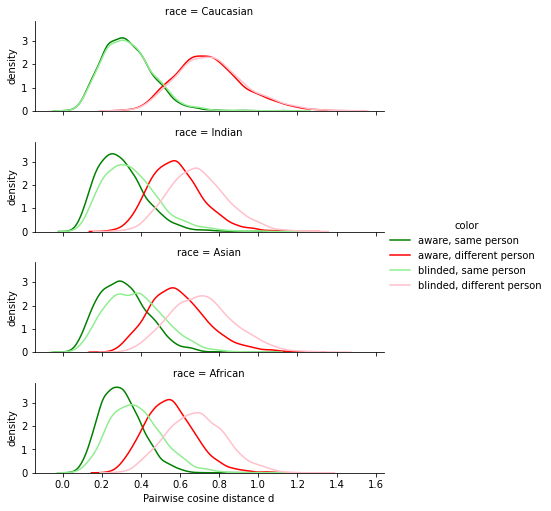

In [60]:
palette = {'aware, same person':'green',
           'aware, different person':'red', 
           'blinded, same person':'lightgreen',
           'blinded, different person':'pink'}
g = sns.FacetGrid(dist_df,row='race',hue='color',aspect=3,height=1.8, legend_out=True,palette=palette)
g.map_dataframe(sns.kdeplot,'cos',palette=palette)
g.add_legend()
for ax in g.axes.flat:
    ax.set_ylabel('density')
plt.xlabel('Pairwise cosine distance d')    
g.savefig("latex/bias.eps")

In [61]:
# "aware" accuracy
sel = dist_df.type == 'aware'
xp = dist_df[sel].cos.values.reshape([-1,1])
yp = dist_df[sel].issame.values
clf = LogisticRegression(random_state=0,max_iter=200).fit(xp, yp)
print('Total = ',clf.score(xp,yp))
for race in hlp.H5Reader.race_list:
    sel = (dist_df.type == 'aware') & (dist_df.race == race)
    xp = dist_df[sel].cos.values.reshape([-1,1])
    yp = dist_df[sel].issame.values
    print(race,'=',clf.score(xp,yp))

Total =  0.8641129714189075
Caucasian = 0.9065579340808698
Indian = 0.8635669438316647
Asian = 0.844248388191381
African = 0.8424485699949824


In [62]:
# "blinded" accuracy
sel = dist_df.type == 'blinded'
xp = dist_df[sel].cos.values.reshape([-1,1])
yp = dist_df[sel].issame.values
clf = LogisticRegression(random_state=0,max_iter=200).fit(xp, yp)
print('Total = ',clf.score(xp,yp))
for race in hlp.H5Reader.race_list:
    sel = (dist_df.type == 'blinded') & (dist_df.race == race)
    xp = dist_df[sel].cos.values.reshape([-1,1])
    yp = dist_df[sel].issame.values
    print(race,'=',clf.score(xp,yp))

Total =  0.8818281752071706
Caucasian = 0.9235474006116208
Indian = 0.883590700831495
Asian = 0.8610451306413301
African = 0.8595082789764175


## Nearest neighbor metric

In [5]:
from sklearn.neighbors import NearestNeighbors
from sklearn.model_selection import train_test_split

def nn_metric(X, race_label, id_label, sample_sel = None):
    if sample_sel is None:
        X2 = X
        sample_sel = np.arange(X.shape[0])
    else:
        X2 = X[sample_sel]
    nbrs = NearestNeighbors(n_neighbors=2, algorithm='ball_tree').fit(X)
    indices = nbrs.kneighbors(X2,return_distance=False)
    df = pd.DataFrame(indices, columns=['ind','nn_ind'])
    df['race'] = race_label[indices[:,0]]
    df['id'] = id_label[indices[:,0]]
    df['nn_race'] = race_label[indices[:,1]]
    df['nn_id'] = id_label[indices[:,1]]
    df['same'] = df.id == df.nn_id
    df['diff_race'] = df.race != df.nn_race
    return df

id_labels = hlp.H5Reader('senet50_128').read_pair_labels()
id_labels = np.array([label[:-5] for label in id_labels])
_, sel = train_test_split(np.arange(len(yr)),test_size=0.01)

In [42]:
nbrs.kneighbors(X128[0:100],return_distance=False)[:,1]

array([ 2, 65,  0,  5,  3,  3,  5,  8,  7,  7, 11, 10, 11, 14, 13, 13, 18,
       16, 16, 21, 19, 19, 23, 25, 22, 26, 25, 29, 27, 27, 32, 34, 30, 30,
       32, 33, 37, 36, 36, 40, 39, 42, 41, 44, 43, 41, 48, 48, 46, 50, 52,
       50, 50, 55, 53, 53, 57, 56, 99, 61, 61, 59, 61, 65, 65, 63, 68, 68,
       67, 73, 72, 69, 70, 72, 72, 76, 75, 75, 79, 78, 79, 82, 81, 82, 85,
       84, 90, 85, 89, 88, 85, 95, 95, 95, 95, 94, 97, 96, 99, 98],
      dtype=int64)

In [47]:
def hdf_add_col(path, key, col, data):
    with pd.HDFStore(mystore) as store:
        keys = store.keys()
    if key in [key.strip('/') for key in keys]:
        df = pd.read_hdf(path, key)
        df[col] = data
    else:
        df = pd.DataFrame(data,columns=[col])
    df.to_hdf(path, key)

In [51]:
from sklearn.neighbors import NearestNeighbors
def nn_ind(x):
    nbrs = NearestNeighbors(n_neighbors=2, algorithm='ball_tree').fit(x)
    return nbrs.kneighbors(x,return_distance=False)[:,1]

def normX(x):
    return x / np.linalg.norm(x,axis=1,keepdims=True)

In [67]:
nnkey = 'nn_indices'
X, tag = X128,'128'
hdf_add_col(mystore,nnkey,tag+'-n-e',nn_ind(X).astype(np.uint16))
hdf_add_col(mystore,nnkey,tag+'-r-e',nn_ind(blind(X,yr)[0]).astype(np.uint16))
hdf_add_col(mystore,nnkey,tag+'-r-c',nn_ind(normX(blind(X,yr)[0])).astype(np.uint16))
hdf_add_col(mystore,nnkey,tag+'-g-e',nn_ind(blind(X,yg)[0]).astype(np.uint16))
hdf_add_col(mystore,nnkey,tag+'-g-c',nn_ind(normX(blind(X,yg)[0])).astype(np.uint16))

eigenvalues of B = [1. 1. 1.]
eigenvalues of B = [1. 1. 1.]
eigenvalues of B = [1.]
eigenvalues of B = [1.]


In [68]:
X, tag = X256,'256'
hdf_add_col(mystore,nnkey,tag+'-n-e',nn_ind(X).astype(np.uint16))
hdf_add_col(mystore,nnkey,tag+'-r-e',nn_ind(blind(X,yr)[0]).astype(np.uint16))
hdf_add_col(mystore,nnkey,tag+'-r-c',nn_ind(normX(blind(X,yr)[0])).astype(np.uint16))
hdf_add_col(mystore,nnkey,tag+'-g-e',nn_ind(blind(X,yg)[0]).astype(np.uint16))
hdf_add_col(mystore,nnkey,tag+'-g-c',nn_ind(normX(blind(X,yg)[0])).astype(np.uint16))

eigenvalues of B = [1. 1. 1.]
eigenvalues of B = [1. 1. 1.]
eigenvalues of B = [1.]
eigenvalues of B = [1.]


In [69]:
X, tag = Xft,'ft'
hdf_add_col(mystore,nnkey,tag+'-n-e',nn_ind(X).astype(np.uint16))
hdf_add_col(mystore,nnkey,tag+'-r-e',nn_ind(blind(X,yr)[0]).astype(np.uint16))
hdf_add_col(mystore,nnkey,tag+'-r-c',nn_ind(normX(blind(X,yr)[0])).astype(np.uint16))
hdf_add_col(mystore,nnkey,tag+'-g-e',nn_ind(blind(X,yg)[0]).astype(np.uint16))
hdf_add_col(mystore,nnkey,tag+'-g-c',nn_ind(normX(blind(X,yg)[0])).astype(np.uint16))

eigenvalues of B = [1. 1. 1.]
eigenvalues of B = [1. 1. 1.]
eigenvalues of B = [1.]
eigenvalues of B = [1.]


In [71]:
# blinded with respect to gender and race
hdf_add_col(mystore,nnkey,'128-rg-e',nn_ind(blind(X128,yr,yg)[0]).astype(np.uint16))
hdf_add_col(mystore,nnkey,'128-rg-c',nn_ind(normX(blind(X128,yr,yg)[0])).astype(np.uint16))
hdf_add_col(mystore,nnkey,'256-rg-e',nn_ind(blind(X256,yr,yg)[0]).astype(np.uint16))
hdf_add_col(mystore,nnkey,'256-rg-c',nn_ind(normX(blind(X256,yr,yg)[0])).astype(np.uint16))
hdf_add_col(mystore,nnkey,'ft-rg-e',nn_ind(blind(Xft,yr,yg)[0]).astype(np.uint16))
hdf_add_col(mystore,nnkey,'ft-rg-c',nn_ind(normX(blind(Xft,yr,yg)[0])).astype(np.uint16))

eigenvalues of B = [1. 1. 1. 1.]
eigenvalues of B = [1. 1. 1. 1.]
eigenvalues of B = [1. 1. 1. 1.]
eigenvalues of B = [1. 1. 1. 1.]
eigenvalues of B = [1. 1. 1. 1.]
eigenvalues of B = [1. 1. 1. 1.]


In [72]:
pd.read_hdf(mystore,nnkey)

,128-n-e,128-r-e,128-r-c,128-g-e,128-g-c,256-n-e,256-r-e,256-r-c,256-g-e,256-g-c,...,ft-r-e,ft-r-c,ft-g-e,ft-g-c,128-rg-e,128-rg-c,256-rg-e,256-rg-c,ft-rg-e,ft-rg-c
0,36116,26890,26890,3668,36116,36116,13602,36116,36116,36116,...,17054,17054,8916,8916,26890,26890,13602,36116,11147,11147
1,6090,21869,21869,6090,6090,2124,2124,2124,2124,2124,...,8120,8120,9978,9978,23949,21869,2124,2124,8120,8120
2,1716,35863,35863,1716,1716,9995,9995,9995,9995,9995,...,1716,1716,1716,1716,35863,35863,9995,9995,1716,1716
3,5,5,5,5,5,4,4,4,4,4,...,5,5,5,5,5,5,4,4,5,5
4,3,3,3,3,3,6,6,6,6,6,...,3,3,3,3,3,3,6,6,3,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40314,40313,40313,40313,40313,40313,40313,40313,40313,40313,40313,...,40313,40313,40313,40313,40313,40313,40313,40313,40313,40313
40315,40312,40312,40313,40312,40312,40313,40313,40313,40313,40313,...,40312,40312,40312,40312,40312,40313,40313,40313,40312,40312
40316,40318,40318,40318,40318,40318,40318,40318,40318,40318,40318,...,40318,40318,40318,40318,40318,40318,40318,40318,40318,40318
40317,40318,40318,40318,40318,40318,40318,40318,40318,40318,40318,...,40318,40318,40318,40318,40318,40318,40318,40318,40318,40318


In [73]:
import sys
sys.getsizeof(pd.read_hdf(mystore,nnkey))

2015974

In [ ]:
X_dict = {'128 None': X128,
          '128 Blinded': blind(X128,yr)[0],
          '256 None': X256,
          '256 Blinded': blind(X256,yr)[0],
          'ft None': Xft,
          'ft Blinded': blind(Xft,yr)[0]}

X_dict['128 Blinded Cos'] = normX(X_dict['128 Blinded'])
X_dict['256 Blinded Cos'] = normX(X_dict['256 Blinded'])
X_dict['ft Blinded Cos'] = normX(X_dict['ft Blinded'])

In [67]:
#df = []
for name, X in list(X_dict.items())[-1:]:
    tmp = nn_metric(X, yr, id_labels)
    df.append(tmp[['race','same']]
             .groupby('race').mean().rename(columns={'same':name}).T)
    print(name,'done...')

ft Blinded Cos done...


In [68]:
df2 = pd.concat(df,0)

race,0,1,2,3
128 None,0.890583,0.851747,0.830417,0.797231
128 Blinded,0.833350,0.828423,0.807604,0.778045
256 None,0.878701,0.825130,0.797438,0.757188
256 Blinded,0.868106,0.822361,0.794834,0.756518
ft None,0.879889,0.845251,0.829723,0.793843
ft Blinded,0.856818,0.823305,0.808165,0.784842
128 Blinded Cos,0.864739,0.826274,0.802645,0.776142
256 Blinded Cos,0.875928,0.823955,0.797438,0.757284
ft Blinded Cos,0.860481,0.824122,0.812018,0.786243


In [71]:
df2.to_hdf(mystore,'ethnicity_fr_rates')

In [69]:
print(df2.assign(av = np.mean(df2.values,1)).sort_index().round(4).to_latex())

\begin{tabular}{lrrrrr}
\toprule
race &       0 &       1 &       2 &       3 &      av \\
\midrule
128 Blinded     &  0.8333 &  0.8284 &  0.8076 &  0.7780 &  0.8119 \\
128 Blinded Cos &  0.8647 &  0.8263 &  0.8026 &  0.7761 &  0.8175 \\
128 None        &  0.8906 &  0.8517 &  0.8304 &  0.7972 &  0.8425 \\
256 Blinded     &  0.8681 &  0.8224 &  0.7948 &  0.7565 &  0.8105 \\
256 Blinded Cos &  0.8759 &  0.8240 &  0.7974 &  0.7573 &  0.8137 \\
256 None        &  0.8787 &  0.8251 &  0.7974 &  0.7572 &  0.8146 \\
ft Blinded      &  0.8568 &  0.8233 &  0.8082 &  0.7848 &  0.8183 \\
ft Blinded Cos  &  0.8605 &  0.8241 &  0.8120 &  0.7862 &  0.8207 \\
ft None         &  0.8799 &  0.8453 &  0.8297 &  0.7938 &  0.8372 \\
\bottomrule
\end{tabular}



In [70]:
print(((df2/np.mean(df2.values,1,keepdims=True)-1)*100).sort_index().round(4).to_latex())

\begin{tabular}{lrrrr}
\toprule
race &       0 &       1 &       2 &       3 \\
\midrule
128 Blinded     &  2.6476 &  2.0407 & -0.5237 & -4.1646 \\
128 Blinded Cos &  5.7849 &  1.0794 & -1.8111 & -5.0533 \\
128 None        &  5.7079 &  1.0982 & -1.4336 & -5.3725 \\
256 Blinded     &  7.1134 &  1.4691 & -1.9274 & -6.6552 \\
256 Blinded Cos &  7.6540 &  1.2664 & -1.9927 & -6.9277 \\
256 None        &  7.8671 &  1.2909 & -2.1085 & -7.0495 \\
ft Blinded      &  4.7093 &  0.6138 & -1.2364 & -4.0867 \\
ft Blinded Cos  &  4.8452 &  0.4150 & -1.0598 & -4.2003 \\
ft None         &  5.1020 &  0.9645 & -0.8903 & -5.1761 \\
\bottomrule
\end{tabular}



In [78]:
X_dict = {'G 128 None': X128,
          'G 128 Blinded': blind(X128,yg)[0],
          'G 256 None': X256,
          'G 256 Blinded': blind(X256,yg)[0],
          'G ft None': Xft,
          'G ft Blinded': blind(Xft,yg)[0]}

X_dict['G 128 Blinded Cos'] = normX(X_dict['G 128 Blinded'])
X_dict['G 256 Blinded Cos'] = normX(X_dict['G 256 Blinded'])
X_dict['G ft Blinded Cos'] = normX(X_dict['G ft Blinded'])

eigenvalues of B = [1.]
eigenvalues of B = [1.]
eigenvalues of B = [1.]


In [80]:
#df = []
for name, X in list(X_dict.items())[:-1]:
    tmp = nn_metric(X, yg, id_labels)
    df.append(tmp[['race','same']]
             .groupby('race').mean().rename(columns={'same':name}).T)
    print(name,'done...')

G 128 None done...
G 128 Blinded done...
G 256 None done...
G 256 Blinded done...
G ft None done...
G ft Blinded done...
G 128 Blinded Cos done...
G 256 Blinded Cos done...


In [83]:
tmp

,ind,nn_ind,race,id,nn_race,nn_id,same,diff_race
0,0,36116,0.0,Caucasian_0cl29w,1.0,African_0276cpn,False,True
1,1,2124,0.0,Caucasian_0cl29w,0.0,Caucasian_01d8v3,False,False
2,2,9995,0.0,Caucasian_0cl29w,0.0,Caucasian_055lvl,False,False
3,3,4,0.0,Caucasian_02qtdjx,0.0,Caucasian_02qtdjx,True,False
4,4,6,0.0,Caucasian_02qtdjx,0.0,Caucasian_02qtdjx,True,False
...,...,...,...,...,...,...,...,...
40314,40314,40313,0.0,African_0bmgl10,0.0,African_0bmgl10,True,False
40315,40315,40313,0.0,African_0bmgl10,0.0,African_0bmgl10,True,False
40316,40316,40318,0.0,African_05c1c5,0.0,African_05c1c5,True,False
40317,40317,40318,0.0,African_05c1c5,0.0,African_05c1c5,True,False


In [75]:
df1 = nn_metric(X, y, id_labels, sample_sel = sel)
df2 = nn_metric(Xb, y, id_labels, sample_sel = sel)
df3 = nn_metric(Xb/np.linalg.norm(Xb,axis=1,keepdims=True), y, id_labels, sample_sel = sel)

In [76]:
pd.concat([df1[['race','same','diff_race']].groupby('race').mean().rename(columns={'same':'X'}),
           df2[['race','same','diff_race']].groupby('race').mean().rename(columns={'same':'Xb eucl'}),
           df3[['race','same','diff_race']].groupby('race').mean().rename(columns={'same':'Xb cos'})],1)

,X,diff_race,Xb eucl,diff_race,Xb cos,diff_race
race,,,,,,
0,0.876190,0.019048,0.885714,0.009524,0.876190,0.009524
1,0.817308,0.038462,0.836538,0.038462,0.836538,0.048077
2,0.836735,0.010204,0.836735,0.010204,0.826531,0.010204
3,0.804124,0.010309,0.804124,0.010309,0.804124,0.010309


In [77]:
df1 = nn_metric(X, y, id_labels)
df2 = nn_metric(Xb, y, id_labels)
df3 = nn_metric(Xb/np.linalg.norm(Xb,axis=1,keepdims=True), y, id_labels)

In [78]:
pd.concat([df1[['race','same','diff_race']].groupby('race').mean().rename(columns={'same':'X'}),
           df2[['race','same','diff_race']].groupby('race').mean().rename(columns={'same':'Xb eucl'}),
           df3[['race','same','diff_race']].groupby('race').mean().rename(columns={'same':'Xb cos'})],1)

,X,diff_race,Xb eucl,diff_race,Xb cos,diff_race
race,,,,,,
0,0.890583,0.019408,0.890979,0.015150,0.891177,0.011981
1,0.851747,0.017125,0.849692,0.017419,0.847794,0.021227
2,0.830417,0.007708,0.829688,0.008646,0.828925,0.009371
3,0.797231,0.007499,0.795789,0.007692,0.796017,0.006928


# Senet 256

In [6]:
# loading the data
df = hlp.H5Reader('senet50_256').read_all()
X, y = hlp.H5Reader.df2data(df)   # X = empeddings, y = race index
race_labels = pd.Series(y).apply(hlp.H5Reader.race).values

y_unique = np.unique(y)  
Ne = X.shape[1]  # size of the empedding space
centers = np.array([np.mean(X[y==k,:],0) for k in y_unique])  # centers of the clusters
V = np.array([centers[k] - np.mean(centers[y_unique!=k,:],0) for k in y_unique]) 
B = orth(V.T).T  
P = np.eye(Ne) - np.matmul(B.T,B)
Xb = np.matmul(X,P)

print('eigenvalues of V =',np.linalg.svd(V)[1])
print('eigenvalues of B =',np.linalg.svd(B)[1])

eigenvalues of V = [4.1874722e-01 3.8515702e-01 2.4120535e-01 1.0436710e-08]
eigenvalues of B = [1.0000001  0.99999994 0.9999997 ]


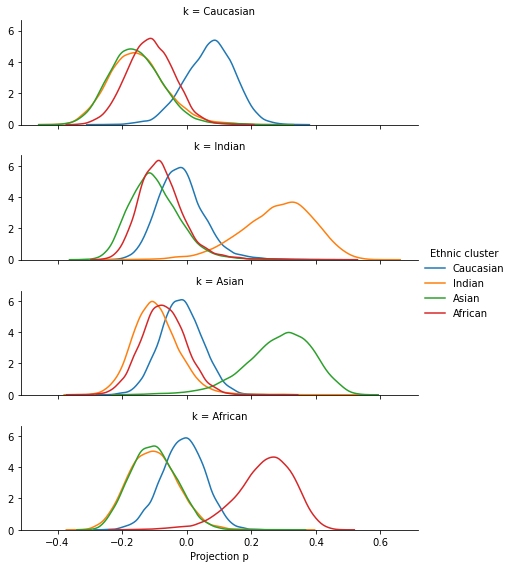

In [7]:
# normalized vectors for subsequent projections in the vis
U = V / np.linalg.norm(V,axis=1,keepdims=True) # normalizing
pu = np.matmul(X,U.T)

tmp = (pd.DataFrame(pu, columns = hlp.H5Reader.race_list, index = race_labels)
       .stack().reset_index()
       .rename(columns={'level_0':'Ethnic cluster','level_1':'k',0:'Projection p'}) )

g = sns.FacetGrid(tmp,row='k',hue='Ethnic cluster',aspect=3,height=2, legend_out=True)
g.map(sns.kdeplot, 'Projection p')
g.add_legend()
g.savefig("latex/projection256.eps")

## Recognition rate and Bais

In [8]:
img_labels = hlp.H5Reader('senet50_128').read_pair_labels()
frm = hlp.RFWDistances()
dist_df = pd.concat([
    frm.get_distance_df(X,img_labels).dropna().assign(type='aware'),
    frm.get_distance_df(Xb,img_labels).dropna().assign(type='blinded')],0)
dist_df['color'] = dist_df.type + ', ' + dist_df.issame.apply(lambda val: {0:'different person', 1:'same person'}[val])
dist_df.head()

,race,label1,label2,issame,cos,eucl,type,color
0,Caucasian,Caucasian_027n6t8_0003,Caucasian_027n6t8_0002,1,0.442953,0.941226,aware,"aware, same person"
1,Caucasian,Caucasian_016lb3_0004,Caucasian_016lb3_0002,1,0.344146,0.829634,aware,"aware, same person"
2,Caucasian,Caucasian_02_4qt_0003,Caucasian_02_4qt_0002,1,0.488419,0.988351,aware,"aware, same person"
3,Caucasian,Caucasian_09g8fj_0003,Caucasian_09g8fj_0001,1,0.320257,0.800322,aware,"aware, same person"
4,Caucasian,Caucasian_01q3xr_0001,Caucasian_01q3xr_0003,1,0.302051,0.777240,aware,"aware, same person"


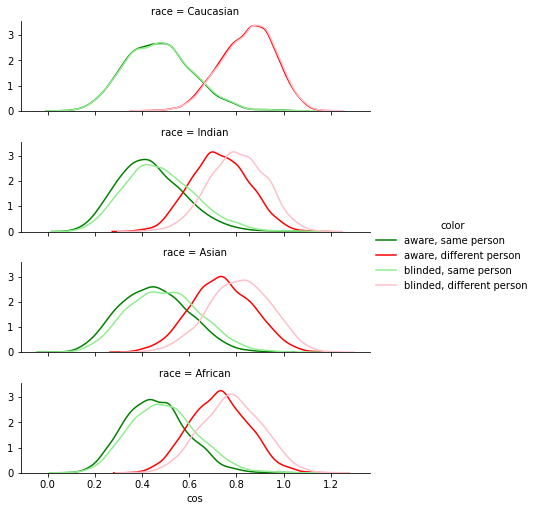

In [9]:
palette = {'aware, same person':'green',
           'aware, different person':'red', 
           'blinded, same person':'lightgreen',
           'blinded, different person':'pink'}
g = sns.FacetGrid(dist_df,row='race',hue='color',aspect=3,height=1.8, legend_out=True,palette=palette)
g.map_dataframe(sns.kdeplot,'cos',palette=palette)
g.add_legend()
g.savefig("latex/bias256.eps")

In [10]:
# "aware" accuracy
from sklearn.linear_model import LogisticRegression
sel = dist_df.type == 'aware'
xp = dist_df[sel].cos.values.reshape([-1,1])
yp = dist_df[sel].issame.values
clf = LogisticRegression(random_state=0,max_iter=200).fit(xp, yp)
print('Total = ',clf.score(xp,yp))
for race in hlp.H5Reader.race_list:
    sel = (dist_df.type == 'aware') & (dist_df.race == race)
    xp = dist_df[sel].cos.values.reshape([-1,1])
    yp = dist_df[sel].issame.values
    print(race,'=',clf.score(xp,yp))

Total =  0.8628023000169119
Caucasian = 0.9057084607543323
Indian = 0.8591549295774648
Asian = 0.8417034272141161
African = 0.8449573507275464


In [11]:
# "blinded" accuracy
sel = dist_df.type == 'blinded'
xp = dist_df[sel].cos.values.reshape([-1,1])
yp = dist_df[sel].issame.values
clf = LogisticRegression(random_state=0,max_iter=200).fit(xp, yp)
print('Total = ',clf.score(xp,yp))
for race in hlp.H5Reader.race_list:
    sel = (dist_df.type == 'blinded') & (dist_df.race == race)
    xp = dist_df[sel].cos.values.reshape([-1,1])
    yp = dist_df[sel].issame.values
    print(race,'=',clf.score(xp,yp))

Total =  0.88030610519195
Caucasian = 0.9232076112810058
Indian = 0.8844391651111488
Asian = 0.8659653885307091
African = 0.8481351396554608


# Senet ft

In [11]:
# loading the data
df = hlp.H5Reader('senet50_ft').read_all()
X, y = hlp.H5Reader.df2data(df)   # X = empeddings, y = race index
race_labels = pd.Series(y).apply(hlp.H5Reader.race).values

y_unique = np.unique(y)  
Ne = X.shape[1]  # size of the empedding space
centers = np.array([np.mean(X[y==k,:],0) for k in y_unique])  # centers of the clusters
V = np.array([centers[k] - np.mean(centers[y_unique!=k,:],0) for k in y_unique]) 
B = orth(V.T).T  
P = np.eye(Ne) - np.matmul(B.T,B)
Xb = np.matmul(X,P)

print('eigenvalues of V =',np.linalg.svd(V)[1])
print('eigenvalues of B =',np.linalg.svd(B)[1])

eigenvalues of V = [3.9002421e-01 2.9777420e-01 2.2762212e-01 3.5975152e-08]
eigenvalues of B = [1.0000002 1.0000001 1.       ]


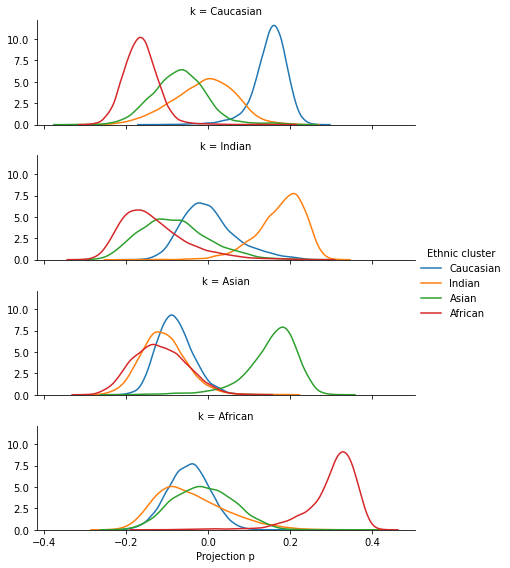

In [12]:
# normalized vectors for subsequent projections in the vis
U = V / np.linalg.norm(V,axis=1,keepdims=True) # normalizing
pu = np.matmul(X,U.T)

tmp = (pd.DataFrame(pu, columns = hlp.H5Reader.race_list, index = race_labels)
       .stack().reset_index()
       .rename(columns={'level_0':'Ethnic cluster','level_1':'k',0:'Projection p'}) )

g = sns.FacetGrid(tmp,row='k',hue='Ethnic cluster',aspect=3,height=2, legend_out=True)
g.map(sns.kdeplot, 'Projection p')
g.add_legend()
g.savefig("latex/projection_ft.eps")

## Recognition rate and Bais

In [13]:
img_labels = hlp.H5Reader('senet50_128').read_pair_labels()
frm = hlp.RFWDistances()
dist_df = pd.concat([
    frm.get_distance_df(X,img_labels).dropna().assign(type='aware'),
    frm.get_distance_df(Xb,img_labels).dropna().assign(type='blinded')],0)
dist_df['color'] = dist_df.type + ', ' + dist_df.issame.apply(lambda val: {0:'different person', 1:'same person'}[val])
dist_df.head()

,race,label1,label2,issame,cos,eucl,type,color
0,Caucasian,Caucasian_027n6t8_0003,Caucasian_027n6t8_0002,1,0.186506,0.610747,aware,"aware, same person"
1,Caucasian,Caucasian_016lb3_0004,Caucasian_016lb3_0002,1,0.208772,0.646177,aware,"aware, same person"
2,Caucasian,Caucasian_02_4qt_0003,Caucasian_02_4qt_0002,1,0.147476,0.543096,aware,"aware, same person"
3,Caucasian,Caucasian_09g8fj_0003,Caucasian_09g8fj_0001,1,0.166379,0.576852,aware,"aware, same person"
4,Caucasian,Caucasian_01q3xr_0001,Caucasian_01q3xr_0003,1,0.133207,0.516153,aware,"aware, same person"


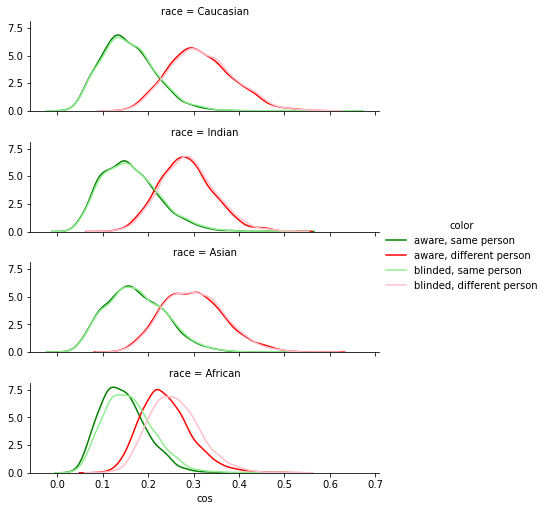

In [14]:
palette = {'aware, same person':'green',
           'aware, different person':'red', 
           'blinded, same person':'lightgreen',
           'blinded, different person':'pink'}
g = sns.FacetGrid(dist_df,row='race',hue='color',aspect=3,height=1.8, legend_out=True,palette=palette)
g.map_dataframe(sns.kdeplot,'cos')
g.add_legend()
g.savefig("latex/bias_ft.eps")

In [16]:
# "aware" accuracy
from sklearn.linear_model import LogisticRegression
sel = dist_df.type == 'aware'
xp = dist_df[sel].cos.values.reshape([-1,1])
yp = dist_df[sel].issame.values
clf = LogisticRegression(random_state=0,max_iter=200).fit(xp, yp)
print('Total = ',clf.score(xp,yp))
for race in hlp.H5Reader.race_list:
    sel = (dist_df.type == 'aware') & (dist_df.race == race)
    xp = dist_df[sel].cos.values.reshape([-1,1])
    yp = dist_df[sel].issame.values
    print(race,'=',clf.score(xp,yp))

Total =  0.8312616269237274
Caucasian = 0.8904179408766565
Indian = 0.8499915153572034
Asian = 0.822361723786902
African = 0.7633383508947985


In [17]:
# "blinded" accuracy
sel = dist_df.type == 'blinded'
xp = dist_df[sel].cos.values.reshape([-1,1])
yp = dist_df[sel].issame.values
clf = LogisticRegression(random_state=0,max_iter=200).fit(xp, yp)
print('Total = ',clf.score(xp,yp))
for race in hlp.H5Reader.race_list:
    sel = (dist_df.type == 'blinded') & (dist_df.race == race)
    xp = dist_df[sel].cos.values.reshape([-1,1])
    yp = dist_df[sel].issame.values
    print(race,'=',clf.score(xp,yp))

Total =  0.8394638931168612
Caucasian = 0.8899082568807339
Indian = 0.850330901069065
Asian = 0.8233797081778079
African = 0.7949489881251045
